In [ ]:
!pip install --upgrade pip
!pip install tensorflow tensorflow-hub soundfile matplotlib numpy librosa


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import matplotlib.pyplot as plt
import os
import torch
import torchaudio
from torchaudio.datasets import LIBRISPEECH
from IPython.display import Audio, display
import librosa.display

In [ ]:
yamnet_model_handle = "https://tfhub.dev/google/yamnet/1"
yamnet = hub.load(yamnet_model_handle)
class_map_path = yamnet.class_map_path().numpy().decode('utf-8')
with open(class_map_path, 'r') as f:
  class_names = [l.strip() for l in f.readlines()]
print("Loaded YAMNet; classes:", len(class_names))

Loaded YAMNet; classes: 522


In [ ]:
def load_wav(path, target_sr=16000):
  wav, sr = librosa.load(path, sr=target_sr, mono=True)
  return wav.astype(np.float32), sr

def predict_yamnet(waveform):
  # expects 1-D numpy waveform (float32, 16k)
  scores, embeddings, spec = yamnet(waveform)
  mean_scores = tf.reduce_mean(scores, axis=0).numpy()
  top_index = int(np.argmax(mean_scores))
  return top_index, float(mean_scores[top_index]), mean_scores, scores, embeddings, spec

def save_wav(path, waveform, sr=16000):
  sf.write(path, waveform, sr)

def plot_wave_and_spectrogram(waveform, sr=16000, title="Waveform and Spectrogram"):
  # Ensure waveform is a NumPy array
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.squeeze().cpu().numpy()
    else:
        waveform = np.squeeze(waveform)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    times = np.arange(waveform.shape[0]) / sr

    # Plot waveform
    axes[0].plot(times, waveform)
    axes[0].set_title(f"{title} - Waveform")
    axes[0].set_xlabel("Time [s]")
    axes[0].set_ylabel("Amplitude")

    # Compute and plot Mel spectrogram using torchaudio
    waveform_tensor = torch.tensor(waveform).unsqueeze(0)  # [1, T]
    mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform_tensor)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    axes[1].imshow(mel_spec_db.squeeze().numpy(), origin="lower", aspect="auto", cmap="viridis")
    axes[1].set_title(f"{title} - Mel Spectrogram")
    axes[1].set_xlabel("Frame")
    axes[1].set_ylabel("Mel Frequency Bin")

    plt.tight_layout()
    plt.show()

def compute_snr(clean, adv):
  clean = np.array(clean, dtype=np.float32)
  adv = np.array(adv, dtype=np.float32)
  noise = adv - clean
  sig_pow = np.mean(clean**2)
  noise_pow = np.mean(noise**2)
  return 10 * np.log10(sig_pow / (noise_pow + 1e-12))

100%|██████████| 331M/331M [00:14<00:00, 23.9MB/s]
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/a

Loaded Librispeech sample from speaker 1089, chapter 134686, utterance 0
Sample rate: 16000, waveform shape: torch.Size([1, 166960])
Transcription: HE HOPED THERE WOULD BE STEW FOR DINNER TURNIPS AND CARROTS AND BRUISED POTATOES AND FAT MUTTON PIECES TO BE LADLED OUT IN THICK PEPPERED FLOUR FATTENED SAUCE


/usr/local/lib/python3.12/dist-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


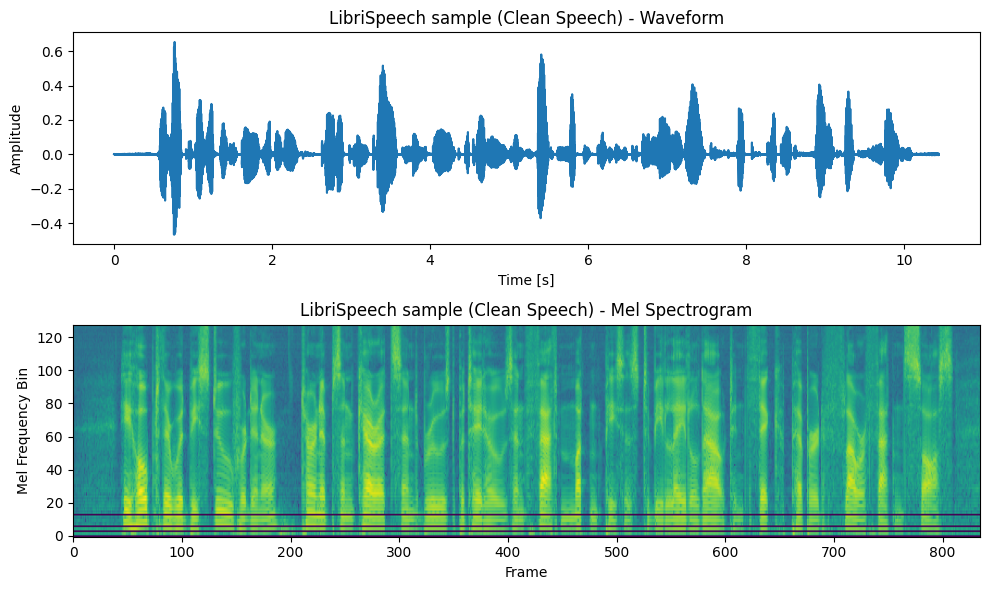

In [ ]:
# Load LibriSpeech sample (clean human speech)

root = "./data"
os.makedirs(root, exist_ok=True)

dataset = LIBRISPEECH(root, url="test-clean", download=True)

waveform, sr, utterance, speaker_id, chapter_id, utterance_id = dataset[0]

print(f"Loaded Librispeech sample from speaker {speaker_id}, chapter {chapter_id}, utterance {utterance_id}")
print(f"Sample rate: {sr}, waveform shape: {waveform.shape}")
print(f"Transcription: {utterance}")

plot_wave_and_spectrogram(waveform, sr, title="LibriSpeech sample (Clean Speech)")
display(Audio(waveform, rate=sr))

In [ ]:
# --- Robust predict function that accepts torch.Tensor or numpy array ---
def predict_yamnet_safe(waveform, sr):
    """
    waveform: torch.Tensor or numpy array. May be shape (1, N) or (N,)
    sr: sample rate (int)
    Returns: top_index, top_score, mean_scores (np.array)
    """
    # 1) Convert to 1-D numpy float32
    if isinstance(waveform, torch.Tensor):
        w = waveform.detach().cpu().squeeze().numpy()
    else:
        w = np.squeeze(np.asarray(waveform))
    w = w.astype(np.float32)

    # 2) Resample to 16000 if needed
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        # resampler expects torch tensor
        w = resampler(torch.tensor(w)).numpy().squeeze().astype(np.float32)
        sr_used = 16000
    else:
        sr_used = sr

    # 3) Ensure shape is (N,)
    if w.ndim != 1:
        w = w.reshape(-1)

    # 4) Convert to tf.Tensor 1-D
    w_tf = tf.convert_to_tensor(w, dtype=tf.float32)

    # 5) Run yamnet: it expects a 1-D float32 waveform sampled at 16k
    scores, embeddings, spec = yamnet(w_tf)
    mean_scores = tf.reduce_mean(scores, axis=0).numpy()
    top_index = int(np.argmax(mean_scores))
    top_score = float(mean_scores[top_index])
    return top_index, top_score, mean_scores, sr_used

# --- Use the function on your loaded waveform (replace 'waveform' and 'sr' if different) ---
top_idx, top_score, mean_scores, used_sr = predict_yamnet_safe(waveform, sr)
print("Prediction (YAMNet):", top_idx, class_names[top_idx], "mean score:", top_score, "| sample rate used:", used_sr)


Prediction (YAMNet): 0 index,mid,display_name mean score: 0.9909453392028809 | sample rate used: 16000


SNR (FGSM): 27.356056


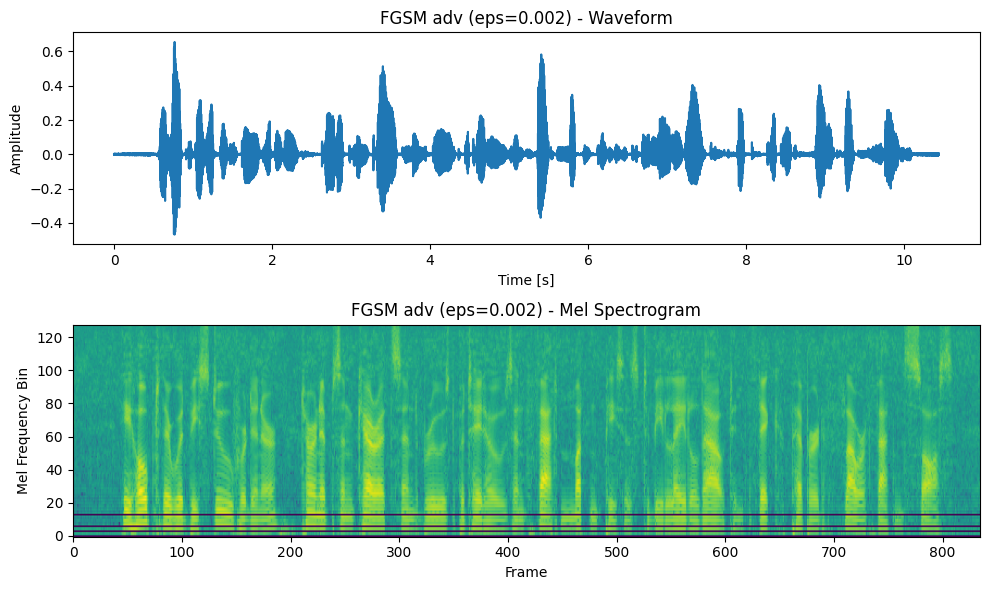

Predicted adv: 0 index,mid,display_name


In [ ]:
#FGSM Attack Implementation
def fgsm_attack(waveform, label_index, epsilon=0.005):
  x = tf.convert_to_tensor(waveform.reshape(1,-1), dtype=tf.float32)

  with tf.GradientTape() as tape:
    tape.watch(x)
    scores, embeddings, spec = yamnet(tf.squeeze(x, axis=0))
    mean_scores = tf.reduce_mean(scores, axis=0)

    n_classes = int(mean_scores.shape[0])

    target = tf.one_hot(label_index, depth=n_classes)
    loss = tf.keras.losses.categorical_crossentropy(target[None,:], mean_scores[None,:])

  grad = tape.gradient(loss, x)
  signed_grad = tf.sign(grad)

  x_adv = x + epsilon * signed_grad
  x_adv = tf.clip_by_value(x_adv, -1.0, 1.0)

  return tf.squeeze(x_adv, axis=0).numpy()

adv = fgsm_attack(waveform, top_idx, epsilon=0.002)
print("SNR (FGSM):", compute_snr(waveform, adv))
plot_wave_and_spectrogram(adv, sr, title="FGSM adv (eps=0.002)")
display(Audio(adv, rate=sr))
pred_idx = predict_yamnet(adv)[0]
print("Predicted adv:", pred_idx, class_names[pred_idx])
save_wav("fgsm_adv.wav", adv, sr)


SNR (PGD): 30.267906


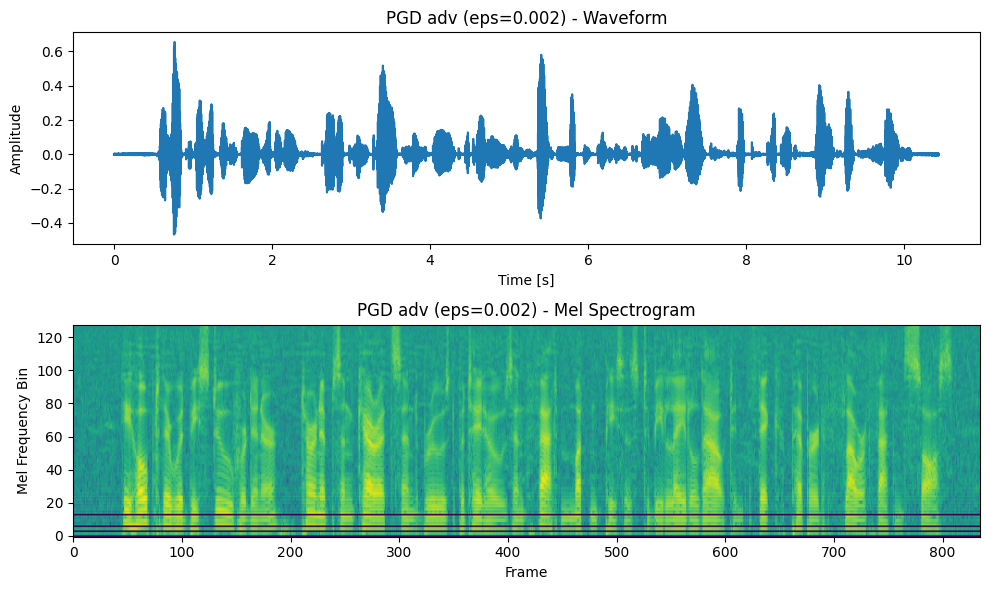

PGD predicted: 122 121,/m/03vt0,Insect


In [ ]:
# PGD Attack Implementation
def pgd_attack(waveform, label_index, epsilon=0.005, alpha=0.001, iters=10):
  x_orig = tf.convert_to_tensor(waveform.reshape(1,-1), dtype=tf.float32)
  x =tf.identity(x_orig)

  for i in range(iters):
    with tf.GradientTape() as tape:
      tape.watch(x)
      scores, embeddings, spec = yamnet(tf.squeeze(x, axis=0))
      mean_scores = tf.reduce_mean(scores, axis=0)

      n_classes = int(mean_scores.shape[0])
      target = tf.one_hot(label_index, depth=n_classes)

      loss = tf.keras.losses.categorical_crossentropy(target[None,:], mean_scores[None,:])

    grad = tape.gradient(loss,x)
    x = x + alpha * tf.sign(grad)
    x = tf.clip_by_value(x, x_orig - epsilon, x_orig + epsilon)
    x = tf.clip_by_value(x, -1.0, 1.0)
  return tf.squeeze(x, axis=0).numpy()


adv_pgd = pgd_attack(waveform, top_idx, epsilon=0.002, alpha=0.001, iters=20)
print("SNR (PGD):", compute_snr(waveform, adv_pgd))
plot_wave_and_spectrogram(adv_pgd, sr, title="PGD adv (eps=0.002)")
display(Audio(adv_pgd, rate=sr))

pred_idx = predict_yamnet(adv_pgd)[0]
print("PGD predicted:", pred_idx, class_names[pred_idx])
save_wav("pgd_adv.wav", adv_pgd, sr)

=== Attack Results Summary Table ===


,epsilon,method,baseline_idx,adv_idx,baseline_conf,adv_conf,snr,success
0,0.001,FGSM,0,0,0.990945,0.859737,33.376652,False
2,0.002,FGSM,0,0,0.990945,0.732217,27.356056,False
4,0.005,FGSM,0,0,0.990945,0.499004,19.397261,False
6,0.010,FGSM,0,0,0.990945,0.458512,13.376660,False
1,0.001,PGD,0,411,0.990945,0.285952,37.601959,True
3,0.002,PGD,0,122,0.990945,0.610028,31.644983,True
5,0.005,PGD,0,67,0.990945,0.473290,23.746555,True
7,0.010,PGD,0,443,0.990945,0.344989,17.746647,True



=== Attack Success Rate (%) ===
method
FGSM      0.0
PGD     100.0
Name: success, dtype: float64


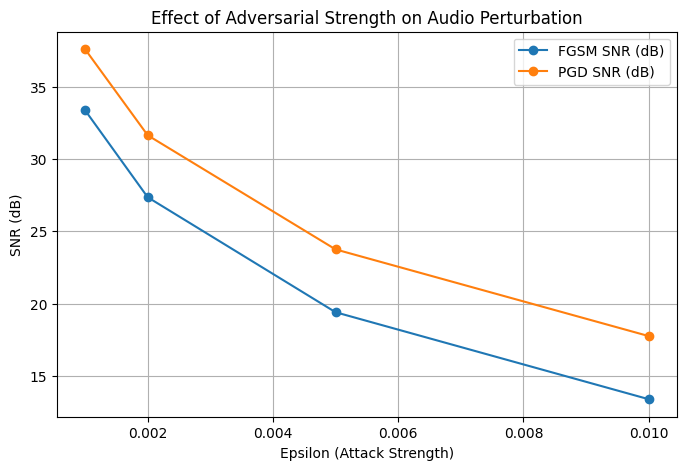

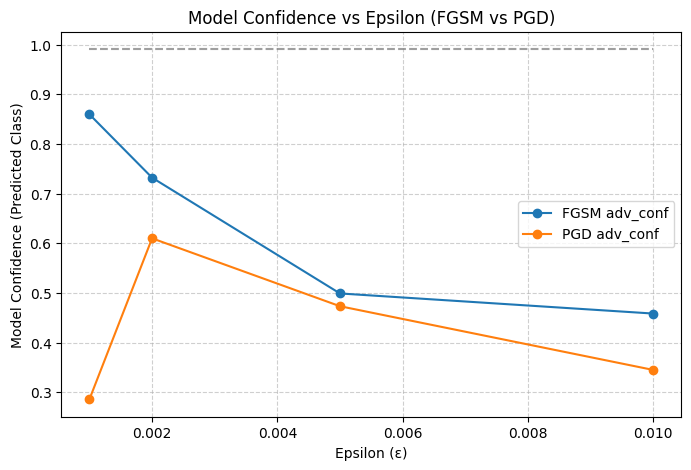

In [ ]:
# Batch test (Run across epsilons and report)
def attack_on_example(wave, method='fgsm', eps=0.002, **kwargs):
    try:
        if isinstance(wave, tf.Tensor):
            wave = wave.numpy()
        wave = np.squeeze(np.array(wave))

        base_idx, base_conf, *_ = predict_yamnet(wave)

        if method == 'fgsm':
            adv = fgsm_attack(wave, base_idx, epsilon=eps)
        else:
            adv = pgd_attack(
                wave, base_idx,
                epsilon=eps,
                alpha=kwargs.get('alpha', eps/5),
                iters=kwargs.get('iters', 10)
            )

        adv_idx, adv_conf, *_ = predict_yamnet(adv)
        snr = compute_snr(wave, adv)
        success = (adv_idx != base_idx)

        return {
            'epsilon': eps,
            'method': method.upper(),
            'baseline_idx': int(base_idx),
            'adv_idx': int(adv_idx),
            'baseline_conf': float(base_conf),
            'adv_conf': float(adv_conf),
            'snr': float(snr),
            'success': bool(success)
        }

    except Exception as e:
        print(f"[!] Attack failed for {method} eps={eps}: {e}")
        return None


# --- Run batch tests (Lower eps) ---
eps_list = [0.001, 0.002, 0.005, 0.01]
results_all = []

for eps in eps_list:
    r1 = attack_on_example(waveform, method='fgsm', eps=eps)
    if r1: results_all.append(r1)
    r2 = attack_on_example(waveform, method='pgd', eps=eps, alpha=eps/5, iters=15)
    if r2: results_all.append(r2)

# --- Convert to DataFrame ---
df_results = pd.DataFrame([r for r in results_all if r is not None])

if not df_results.empty and 'method' in df_results.columns:
    df_results.sort_values(by=['method', 'epsilon'], inplace=True)
else:
    print("[!] Warning: Results missing expected keys — showing raw DataFrame")

print("=== Attack Results Summary Table ===")
display(df_results)

# --- Success rate summary ---
if not df_results.empty and 'success' in df_results.columns:
    success_rate = df_results.groupby('method')['success'].mean() * 100
    print("\n=== Attack Success Rate (%) ===")
    print(success_rate)

# --- SNR vs Epsilon plot ---
if not df_results.empty and 'snr' in df_results.columns:
    plt.figure(figsize=(8, 5))
    for method in df_results['method'].unique():
        subset = df_results[df_results['method'] == method]
        plt.plot(subset['epsilon'], subset['snr'], marker='o', label=f'{method} SNR (dB)')

    plt.xlabel("Epsilon (Attack Strength)")
    plt.ylabel("SNR (dB)")
    plt.title("Effect of Adversarial Strength on Audio Perturbation")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Confidence vs Epsilon Plot ---
plt.figure(figsize=(8, 5))
for method in ['FGSM', 'PGD']:
    subset = df_results[df_results['method'] == method]
    plt.plot(subset['epsilon'], subset['adv_conf'], marker='o', label=f'{method} adv_conf')
    plt.plot(subset['epsilon'], subset['baseline_conf'], '--', color='gray', alpha=0.5, label='_nolegend_')

plt.title("Model Confidence vs Epsilon (FGSM vs PGD)")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Model Confidence (Predicted Class)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()


=== Attack Results Summary Table ===


,epsilon,method,baseline_idx,adv_idx,baseline_conf,adv_conf,snr,success
0,0.01,FGSM,0,0,0.990945,0.458512,13.376660,False
2,0.02,FGSM,0,0,0.990945,0.410333,7.356061,False
4,0.05,FGSM,0,0,0.990945,0.428267,-0.602741,False
6,0.10,FGSM,0,0,0.990945,0.239170,-6.623341,False
1,0.01,PGD,0,443,0.990945,0.344989,17.746647,True
3,0.02,PGD,0,67,0.990945,0.338694,11.741706,True
5,0.05,PGD,0,443,0.990945,0.500064,3.736138,True
7,0.10,PGD,0,132,0.990945,0.427398,-2.280208,True



=== Attack Success Rate (%) ===
method
FGSM      0.0
PGD     100.0
Name: success, dtype: float64


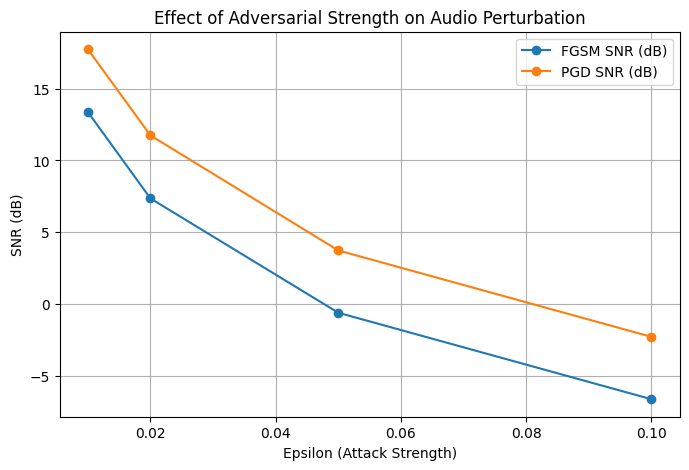

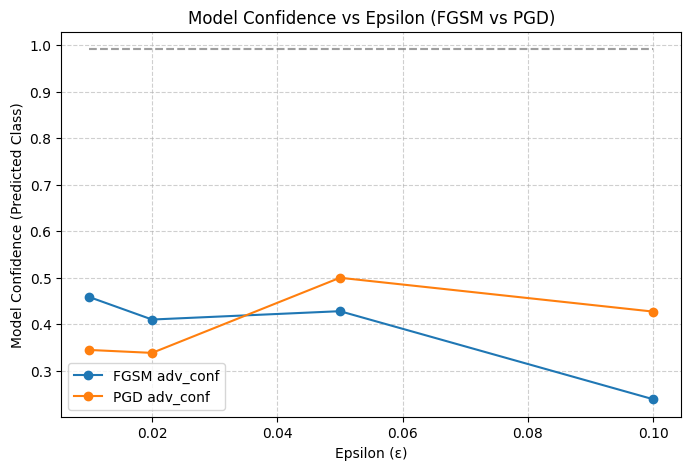

In [ ]:
# --- Run batch tests (Higher eps) ---
eps_list = [0.01, 0.02, 0.05, 0.1]
results_all = []

for eps in eps_list:
    r1 = attack_on_example(waveform, method='fgsm', eps=eps)
    if r1: results_all.append(r1)
    r2 = attack_on_example(waveform, method='pgd', eps=eps, alpha=eps/5, iters=15)
    if r2: results_all.append(r2)

# --- Convert to DataFrame ---
df_results = pd.DataFrame([r for r in results_all if r is not None])

if not df_results.empty and 'method' in df_results.columns:
    df_results.sort_values(by=['method', 'epsilon'], inplace=True)
else:
    print("[!] Warning: Results missing expected keys — showing raw DataFrame")

print("=== Attack Results Summary Table ===")
display(df_results)

# --- Success rate summary ---
if not df_results.empty and 'success' in df_results.columns:
    success_rate = df_results.groupby('method')['success'].mean() * 100
    print("\n=== Attack Success Rate (%) ===")
    print(success_rate)

# --- SNR vs Epsilon plot ---
if not df_results.empty and 'snr' in df_results.columns:
    plt.figure(figsize=(8, 5))
    for method in df_results['method'].unique():
        subset = df_results[df_results['method'] == method]
        plt.plot(subset['epsilon'], subset['snr'], marker='o', label=f'{method} SNR (dB)')

    plt.xlabel("Epsilon (Attack Strength)")
    plt.ylabel("SNR (dB)")
    plt.title("Effect of Adversarial Strength on Audio Perturbation")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Confidence vs Epsilon Plot ---
plt.figure(figsize=(8, 5))
for method in ['FGSM', 'PGD']:
    subset = df_results[df_results['method'] == method]
    plt.plot(subset['epsilon'], subset['adv_conf'], marker='o', label=f'{method} adv_conf')
    plt.plot(subset['epsilon'], subset['baseline_conf'], '--', color='gray', alpha=0.5, label='_nolegend_')

plt.title("Model Confidence vs Epsilon (FGSM vs PGD)")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Model Confidence (Predicted Class)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()